# Tutorial: Inverse Problem Solving with Physics-Informed Neural Network

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial7/tutorial.ipynb)

## Introduction to the Inverse Problem

This tutorial demonstrates how to solve an inverse Poisson problem using Physics-Informed Neural Networks (PINNs).

The problem is defined as a Poisson equation with homogeneous boundary conditions:

\begin{equation}
\begin{cases}
\Delta u = e^{-2(x - \mu_1)^2 - 2(y - \mu_2)^2} \quad \text{in } \Omega, \\
u = 0 \quad \text{on } \partial \Omega, \\
u(\mu_1, \mu_2) = \text{data}
\end{cases}
\end{equation}

Here, $\Omega$ is the square domain $[-2, 2] \times [-2, 2]$, and $\partial \Omega = \Gamma_1 \cup \Gamma_2 \cup \Gamma_3 \cup \Gamma_4$ represents the union of its boundaries.

This type of setup defines an *inverse problem*, which has two primary objectives:

- **Find the solution** $u$ that satisfies the Poisson equation,
- **Identify the unknown parameters** $(\mu_1, \mu_2)$ that best fit the given data (as described by the third equation in the system).

To tackle both objectives, we will define an `InverseProblem` using **PINA**.

Let's begin with the necessary imports:


In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"
    # get the data
    !mkdir "data"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial7/data/pinn_solution_0.5_0.5" -O "data/pinn_solution_0.5_0.5"
    !wget "https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial7/data/pts_0.5_0.5" -O "data/pts_0.5_0.5"

import matplotlib.pyplot as plt
import torch
import warnings

from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import Callback

from pina import Condition, Trainer
from pina.problem import SpatialProblem, InverseProblem
from pina.operator import laplacian
from pina.model import FeedForward
from pina.equation import Equation, FixedValue
from pina.solver import PINN
from pina.domain import CartesianDomain
from pina.optim import TorchOptimizer

warnings.filterwarnings("ignore")
seed_everything(883)

Seed set to 883


883

Next, we import the pre-saved data corresponding to the true parameter values $(\mu_1, \mu_2) = (0.5, 0.5)$.  
These values represent the *optimal parameters* that we aim to recover through neural network training.

In particular, we load:

- `input` points — the spatial coordinates where observations are available,
- `target` points — the corresponding $u$ values (i.e., the solution evaluated at the `input` points).

This data will be used to guide the inverse problem and supervise the network’s prediction of the unknown parameters.

In [2]:
data_output = torch.load(
    "data/pinn_solution_0.5_0.5", weights_only=False
).detach()
data_input = torch.load("data/pts_0.5_0.5", weights_only=False)

Next, let's visualize the data:

- We'll plot the data points, i.e., the spatial coordinates where measurements are available.
- We'll also display the reference solution corresponding to $(\mu_1, \mu_2) = (0.5, 0.5)$.

This serves as the ground truth or expected output that our neural network should learn to approximate through training.

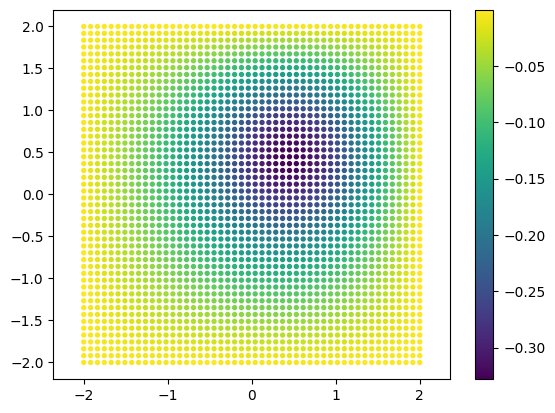

In [3]:
points = data_input.extract(["x", "y"]).detach().numpy()
truth = data_output.detach().numpy()

plt.scatter(points[:, 0], points[:, 1], c=truth, s=8)
plt.axis("equal")
plt.colorbar()
plt.show()

## Inverse Problem Definition in PINA

Next, we initialize the Poisson problem, which inherits from the `SpatialProblem` and `InverseProblem` classes.  
In this step, we need to define all the variables and specify the domain in which our unknown parameters $(\mu_1, \mu_2)$ reside.

Note that the Laplace equation also takes these unknown parameters as inputs. These parameters will be treated as variables that the neural network will optimize during the training process, enabling it to learn the optimal values for $(\mu_1, \mu_2)$.

In [4]:
def laplace_equation(input_, output_, params_):
    """
    Implementation of the laplace equation.

    :param LabelTensor input_: Input data of the problem.
    :param LabelTensor output_: Output data of the problem.
    :param dict params_: Parameters of the problem.
    :return: The residual of the laplace equation.
    :rtype: LabelTensor
    """
    force_term = torch.exp(
        -2 * (input_.extract(["x"]) - params_["mu1"]) ** 2
        - 2 * (input_.extract(["y"]) - params_["mu2"]) ** 2
    )
    delta_u = laplacian(output_, input_, components=["u"], d=["x", "y"])
    return delta_u - force_term


class Poisson(SpatialProblem, InverseProblem):

    output_variables = ["u"]
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    spatial_domain = CartesianDomain({"x": [x_min, x_max], "y": [y_min, y_max]})
    unknown_parameter_domain = CartesianDomain({"mu1": [-1, 1], "mu2": [-1, 1]})

    domains = {
        "boundary": spatial_domain.partial(),
        "D": spatial_domain,
    }

    conditions = {
        "boundary": Condition(domain="boundary", equation=FixedValue(0.0)),
        "D": Condition(domain="D", equation=Equation(laplace_equation)),
        "data": Condition(input=data_input, target=data_output),
    }


problem = Poisson()

Next, we define the neural network model that will be used for solving the inverse problem. In this case, we use a simple FeedForeard model, but you could build one that imposes *hard constraints* on the boundary conditions, similar to the approach used in the [Wave tutorial](https://mathlab.github.io/PINA/tutorial3/tutorial.html) to have better performances!

In [5]:
model = FeedForward(
    layers=[20, 20, 20],
    func=torch.nn.Softplus,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables),
)

After that, we discretize the spatial domain.

In [6]:
problem.discretise_domain(20, "grid", domains=["D"])
problem.discretise_domain(1000, "random", domains="boundary")

Here, we define a simple callback for the trainer. This callback is used to save the parameters predicted by the neural network during training.  
The parameters are saved every 100 epochs as `torch` tensors in a specified directory (in our case, `tutorial_logs`).

The goal of this setup is to read the saved parameters after training and visualize their trend across the epochs. This allows us to monitor how the predicted parameters evolve throughout the training process.


In [7]:
# temporary directory for saving logs of training
tmp_dir = "tutorial_logs"


class SaveParameters(Callback):
    """
    Callback to save the parameters of the model every 100 epochs.
    """

    def on_train_epoch_end(self, trainer, __):
        if trainer.current_epoch % 100 == 99:
            torch.save(
                trainer.solver.problem.unknown_parameters,
                "{}/parameters_epoch{}".format(tmp_dir, trainer.current_epoch),
            )

Then, we define the `PINN` object and train the solver using the `Trainer`

In [8]:
max_epochs = 1500
pinn = PINN(
    problem, model, optimizer=TorchOptimizer(torch.optim.Adam, lr=0.005)
)
# define the trainer for the solver
trainer = Trainer(
    solver=pinn,
    accelerator="cpu",
    max_epochs=max_epochs,
    default_root_dir=tmp_dir,
    enable_model_summary=False,
    callbacks=[SaveParameters()],
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.


One can now see how the parameters vary during the training by reading the saved solution and plotting them. The plot shows that the parameters stabilize to their true value before reaching the epoch $1000$!

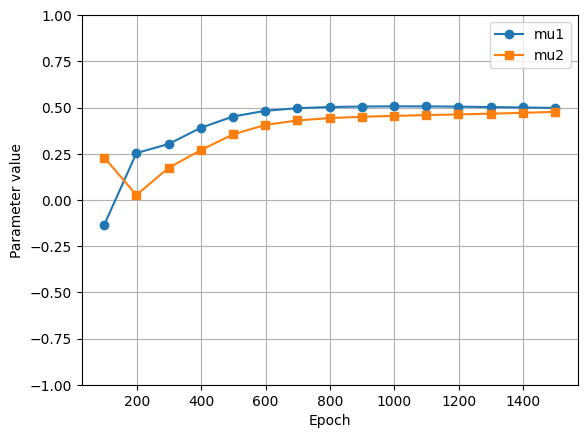

In [9]:
epochs_saved = range(99, max_epochs, 100)
parameters = torch.empty((int(max_epochs / 100), 2))
for i, epoch in enumerate(epochs_saved):
    params_torch = torch.load(
        "{}/parameters_epoch{}".format(tmp_dir, epoch), weights_only=False
    )
    for e, var in enumerate(pinn.problem.unknown_variables):
        parameters[i, e] = params_torch[var].data

# Plot parameters
plt.close()
plt.plot(epochs_saved, parameters[:, 0], label="mu1", marker="o")
plt.plot(epochs_saved, parameters[:, 1], label="mu2", marker="s")
plt.ylim(-1, 1)
plt.grid()
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Parameter value")
plt.show()

## What's Next?

We have covered the basic usage of PINNs for inverse problem modeling. Here are some possible directions for further exploration:

1. **Experiment with different Physics-Informed strategies**: Explore variations in PINN training techniques to improve performance or tackle different types of problems.

2. **Apply to more complex problems**: Scale the approach to higher-dimensional or time-dependent inverse problems.

3. **...and many more!**: The possibilities are endless, from integrating additional physical constraints to testing on real-world datasets.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).